In [1]:
import os
import dask
import time
from distributed import Client
import dask.dataframe as dd
import pandas as pd
import io
import requests
import base64
import binascii
import numpy as np
import dask.bag as db
from numba import njit
import re
from glob import iglob
from scipy.interpolate import BarycentricInterpolator
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# url = 'https://cloud-areapd.pd.infn.it:5210/swift/v1/AUTH_d2e941ce4b324467b6b3d467a923a9bc/MAPD_miniDT_batch/'
# data_names = requests.get(url, verify = False).text
# data_names = data_names.split(sep = '\n')

In [2]:
client = Client()

In [3]:
# client = Client('78.13.47.54:8001') #cluster di mattia

In [4]:
client

Client Scheduler: tcp://127.0.0.1:50921 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 15.92 GiB


In [120]:
path = os.path.join('data_0000*.dat')
all_rec = iglob(path, recursive=True)
data_names = [i for i in all_rec]

# def load_from_file(file): 
#     m = np.fromfile(file, dtype = '<u8')
    

# b = db.from_sequence([])
# for i in data_names:
#     b[i] = (db.from_sequence([i]).map(load_from_file))
# non funziona 

# def load_from_file_all(files):
#     for file in files:
#         m = np.concatenate(m, np.fromfile(file, dtype= '<u8'))
#     m = [*(np.fromfile(file, dtype = '<u8') for file in files)]
#     return m 
# data_names1 = ['data_000001.dat','data_000000.dat']

In [5]:
def convert(mi):
    mat = np.zeros((mi.shape[0], 6), dtype = "u4")
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61
    return mat

def load_from_file(file): 
    m = np.fromfile(file, dtype = '<u8')
    mat = convert(m)
    return mat 

# b = db.from_sequence(data_names).map(load_from_file).flatten()

In [6]:
def load_from_file1(mi):
    m = np.fromfile(file, dtype = '<u8')
    mat = np.zeros((mi.shape[0], 6), dtype = "u4")
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61
    return mat

In [16]:
data_names1 = ['data/data_000000.dat', 'data/data_000001.dat']
b = db.from_sequence(data_names1).map(load_from_file).flatten()

In [17]:
def head(x):
    if x[5] == 2: return x
    
@njit    
def head_filter(x):
    if x[5] == 2: return True 

def head_remove(x):
    return x[5] != 2

# b.map(head).compute()
# questa bag ha lo stesso numero di elementi della prima ma con None al posto di quegli array che non hanno head == 2

# b.remove(head_remove).compute()
# mi sa che remove non è una buona scelta per fare un filtro visto che a differenza di map non so come venga applicata la funzione head_remove
# alla bag 

In [18]:
# %%timeit
# 4.34 s ± 318 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# b1 = b.filter(head_filter)
# d = b1.to_dataframe(meta = [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), ('fpga', 'u1'), ('head', 'u1')])
# d.compute()

# cella che "dimostra" che anche il filtro sulle head sia più conveniente applicarlo direttamente su un dataframe e non su una bag.
# I metodi di una bag sono molto più simili all'apply di un dataframe (fanno cose brutte tipo far comunicare più partizioni tra di loro e 
# fare shuffle) e non sono vettorizzati al contrario delle logical masks dei dataframe

In [19]:
# %%timeit
d = b.to_dataframe(meta = [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), ('fpga', 'u1'), ('head', 'u1')])
d = d[d['head'] == 2]
# d1.compute()

In [20]:
# %%time
# def cut_parall(group): 
#     if group.shape[0] < 15 and group.shape[0] > 3 : return group 
#     else : return None 
    
# d1=d.groupby(['orbit'],group_keys=False)\
#                  .apply(cut_parall, meta =  [('tdc', 'u1'), ('bx', 'u2'), ('orbit', 'u4'), ('chan', 'u2'), ('fpga', 'u1'), ('head', 'u1')])\
#                  .dropna()\
#                  .reset_index()\
#                  .drop(['index'],axis=1)
# d1.compute()

In [21]:
# (d.groupby(['orbit'])['orbit'].count() > 3).index.compute()

In [22]:
cnt = d.orbit.value_counts().compute()
cnt = cnt[(cnt > 3) & (cnt < 16)]
# per rendere più veloce il conto decido di memorizzare in ram gli indici che servono per filtrare il dataframe 

In [23]:
# %%time
# d1 = d[d['orbit'].isin(cnt.index)].compute()
# Il broadcasting senza apply è venti volte più veloce (60 secondi dell'apply contro i 3s invece del broadcasting) 

In [24]:
d1 = d[d['orbit'].isin(cnt.index)] 

In [25]:
lunghezzad1 = len(d1)
lunghezzad = len(d)

In [26]:
# faccio così per evitare di dover calcolare ogni volta le due lunghezze dei dask dataframes. L'operazion fatta tramite dask restituisce
# lo stesso risultato di quella invece fatta sequenzialmente tramite pandas
lunghezzad1/lunghezzad

0.37492972539341696

In [27]:
d1 = d1.persist()
# decido di memorizzare temporaneamente in ram il dataframe con ancora non tutti i filtri effettuati 

In [30]:
d1.compute()

,tdc,bx,orbit,chan,fpga,head
7,29,476,3387200973,126,0,2
11,28,475,3387200973,90,1,2
20,16,485,3387200973,124,0,2
21,5,480,3387200973,127,0,2
24,18,481,3387200973,42,1,2
...,...,...,...,...,...,...
1310700,29,1245,10532373,100,1,2
1310701,3,1247,10532373,98,1,2
1310702,9,1250,10532373,101,1,2
1310703,17,1256,10532373,99,1,2


In [133]:
# potrebbe risultare utile, almeno in questo caso particolare essendo le operazioni da fare indipendenti dal numero di file letti ma funzioni 
# del numero di eventi considerati (tramite le orbits) ripartizionare il dask df. In principio le partizioni sono tante quante il numero di 
# file letti. Potremmo considerare tante partizioni, quante come dice la documentazione di dask 

d1 = d1.repartition(npartitions=12) # tanti quanti sono i threads 

# VEDREMO SUCCESSIVAMENTE QUANTE PARTIZIONI CONVIENE USARE IN BASE NATURALMENTE AL NUMERO DI FILE E ALLE OPERAZIONI CHE DOBBIAMO COMPIERE

In [134]:
d1

,tdc,bx,orbit,chan,fpga,head
npartitions=12,,,,,,
,uint8,uint16,uint32,uint16,uint8,uint8
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [ ]:
# MA CHE CAZZO SUCCEDE PERCHE' QUESTI DUE FILTRI RESTITUISCONO DF DIVERSI?

In [31]:
# fpga_and_chan = 
dprova = d1[d1['orbit'].isin(d1[(d1['fpga'] == 1) & (d1['chan'] == 128)].orbit.compute())]
dprova.compute()

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2


In [33]:
dp = d1.repartition(1)
dp.npartitions

1

In [36]:
dprova2 = dp[dp['orbit'].isin(dp[(dp['fpga'] == 1) & (dp['chan'] == 128)].orbit.compute())]
dprova2.compute().to_csv("s.csv", index = False)

In [38]:
len(dprova2[dprova2.orbit == 10515923])#.compute()

13

In [40]:
def scintillatore(gruppo) :
    if ((gruppo['fpga'] == 1) & (gruppo['chan'] == 128)).any() :
        return gruppo
    else:
        return None
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}
dprova1 = d1.groupby('orbit').apply(scintillatore, meta=tipi).dropna() # dopo apply casta tutto a float per essere compatibile con il None, credo. Per evitare un recast e risparmiare memoria si può usare una flag diversa da None/np.nan MA mi secco per un test del cavolo
x = dprova1.compute()
x

,tdc,bx,orbit,chan,fpga,head
1301238,25,1723,10497098,102,0,2
2245,11,2051,5806689,114,0,2
2246,10,2056,5806689,112,0,2
2247,6,2059,5806689,117,0,2
2248,14,2053,5806689,128,1,2
...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2
1305965,20,2878,10515923,37,0,2


In [41]:
len(x[x.orbit == 10515923])

14

In [42]:
x.to_csv('s1.csv', index = False)

In [43]:
x.drop_duplicates() # interessante...

,tdc,bx,orbit,chan,fpga,head
1301238,25,1723,10497098,102,0,2
2245,11,2051,5806689,114,0,2
2246,10,2056,5806689,112,0,2
2247,6,2059,5806689,117,0,2
2248,14,2053,5806689,128,1,2
...,...,...,...,...,...,...
1305960,29,2868,10515923,40,1,2
1305961,17,2877,10515923,42,1,2
1305962,11,2879,10515923,43,1,2
1305964,24,2875,10515923,107,0,2


In [44]:
x[x.duplicated()]

,tdc,bx,orbit,chan,fpga,head
1301238,25,1723,10497098,102,0,2
1305966,15,2890,10515923,108,0,2


In [45]:
# Filtro di fpga =1 

fpga = d1[d1['fpga'] == 1].orbit.values.compute()
# anche questa volta memorizzo la serie contenente le orbite che devo mantenere nel dataframe. Visto che per ogni evento le hits hanno la 
# stessa orbit allora in questo modo ho selezionato tutte le hit che soddisfano il filtro 

In [46]:
d2 = d1[d1['orbit'].isin(fpga)]

In [47]:
# Filtro di chan = 128

chan = d2[d2['chan'] == 128].orbit.values.compute()
# allo stesso modo per chan memorizzo l'array che mi serve per selezionare gli eventi buoni

In [48]:
d3 = d2[d2['orbit'].isin(chan)]
# facendo compute quindi calcolando esplicitamente il d2 e il d3 perchè ancora d2 è una chiamata non un'esecuzione impieghiamo soltanto un 
# centinaio di millisecondi; il tutto semplicemente memorizzando il dataframe d1 con .persist e aumentando il numero di partizioni a 12. 
# Adesso che però il numero di righe del dataframe è diminuito sarebbe necessario diminuire altrettanto il numero di partizioni

In [163]:
d3.compute()

,tdc,bx,orbit,chan,fpga,head,time
6683,27,878,1118948,91,1,2,21972.500000
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22040.000000
6689,12,884,1118948,88,1,2,22110.000000
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1305961,17,2877,10515923,42,1,2,71939.166667
1305962,11,2879,10515923,43,1,2,71984.166667
1305964,24,2875,10515923,107,0,2,71895.000000
1305965,20,2878,10515923,37,0,2,71966.666667


In [49]:
d3['time'] = 25 * (d3['bx'] + (d3['tdc']/30))

In [241]:
# per rimuovere le orbite con più scintillatori non posso utilizzare il metodo loc in quanto con un dask dataframe non è in grado di 
# aggiungere una colonna al dataframe 

#L'INIZIO DEL DELIRIO 

In [39]:
# prova per elilminare in un modo alternativo i gruppi che hanno più di uno scintillatore 128
# prova = df.groupby(['orbit','chan']).count()
# uau = df3[df3['chan']==128].index
# prova[prova['tdc'] < 2] # qua però voglio selezionare soltanto quelli che hanno il canale 128 e capire a quale orbita corrispondono
# dizio = (df3.groupby(['orbit','chan']).groups) 
# di questi mi interessano quelli che hanno come valore un numero più di due innanzitutto ovvero che hanno un canale che compare sicuramente
# più di una volta. Tra questi ci saranno anche quelli con le chiavi 128 che devo eliminare. Per fare ciò guardo le orbite corrispondenti
# alle chiavi channel = 128 dopo aver effettuato il filtro di valori maggiori di due. Faccio la stessa cosa ma in basso tramite direttamente 
# una series di pandas e trovando un array multiIndex

# indici_filtro = prova[prova['tdc'] > 1].index
# dizio = dict(indici_filtro)
# # np.any(dizio.values()==128) attenzione che così non li troverò mai perchè dizio.values non è un array ma una tuple quindi il broadcasting
# # mi restituisce informazioni sbagliate 
# 128 in list(dizio.values()) #significa che c'è il 128 quindi bisogna trovare le chiavi corrispondenti 

In [240]:
# match = np.array(list(dizio.values())) != 128 # così trovo le posizioni nel dizionario in cui NON ci sono match di valori 128 
# array_orbits = np.array(list(dizio.keys()))
# orbits_tenere = array_orbits[match] 
# ecco trovate le orbite da tenere. Anzichè trovare le orbite da eliminare prendiamo quelle da tenere perchè è più semplice selezionare il 
# dataframe che abbia queste orbite qui 

In [44]:
# MI SONO RICONDOTTO QUINDI SEMPRE AL METODO ISIN PER FARE UN FILTRO. VEDIAMO DI APPLICARE QUESTI METODI AL DASK DATAFRAME

# conteggi = d3.groupby(['orbit','chan']).count()
# indici = conteggi[conteggi['tdc'] > 1].index
# dizionario = dict(indici)
# # già da dizionario iniziano ad essere eseguiti i task delle promesse fatte in conteggi ed indici. 
# match = np.array(list(dizionario.values())) != 128 # così trovo le posizioni nel dizionario in cui NON ci sono match di valori 128 
# array_orbits = np.array(list(dizionario.keys()))
# orbits_tenere = array_orbits[match] 

# d4 = d3[d3['orbit'].isin(orbits_tenere)]
# 119 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# len(d4) = 2954
# C'E' QUALCHE ERRORE PERCHE' E' PIU' STRINGENTE DEGLI ALTRI DUE FATTI CON APPLY E DA MARCO 

In [84]:
# def multiple_scint(group):
#     if group[group.chan==128].shape[0]>1: return None
#     else: return group
    
# metadata=[('tdc', 'u1'),('bx', 'u2'),('orbit', 'u4'),('chan', 'u2'),('fpga', 'u1'),('head', 'u1'),
#          ('time','u2')]

# d4l=d3.groupby("orbit").apply(multiple_scint,meta=metadata).reset_index(drop=True)
# 980 ms ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 
# len(d4l) = 8100

In [50]:
v1, v2 = np.unique((d3['orbit'][d3.chan == 128]).compute(), return_counts = True)
# d3[d3.orbit.isin(v1[v2 > 1])] = None
# d3 = d3.dropna().astype(tipi)
# d3
d5 = d3[d3.orbit.isin(v1[v2 < 2])]

# SCELTA FINALE PER FILTRO DI PIU' SCINTILLATORI PER ORBITA
# 130 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# len(d5) = 8100

In [27]:
# PROVA PARTIZIONI 

# decido in questo momento di ripartizionare in quanto il dataframe iniziale è stato ridotto a tal punto da rendere possibile una suddivisione
# in partizioni con n minore. confronto comunque tramite una semplice operazione nel dataframe come la somma di tutti i valori di una colonna 
# che coinvolge interamente tutte le partizioni in modo che comunichino tra di loro 

# definisco un filtro da usare con apply che effettivamente è un processo che sottointende uno shuffle di tutti i dati nel dataframe e una 
# comunicazione tra le partizioni
def multiple_layers(group):
    
    #obtain all ordered (chamber,layer) pairs
    pairs=pd.Series([(a,b) for a,b in zip(group["chamber"],group["layer"])]) #might be slow
    
    if pairs.duplicated().any(): return None
    else: return group
    
metadata=[('tdc', 'u1'),('bx', 'u2'),('orbit', 'u4'),('chan', 'u2'),('fpga', 'u1'),('head', 'u1'),
         ('time','u2'),('chamber','u1'),('layer','u1'),('cell','u1')]

drep = d5.copy()
n = [i for i in range(2,30,2)]
duration = []

# Scelgo un numero di partizioni multiplo del numero di workers che ho 
for i in range(2,30,2):
    start = time.time()
    #assign chamber values
    drep["chamber"]=None

    masks=[((drep["fpga"]==0)&(drep["chan"]//64==0)),
           ((drep["fpga"]==0)&(drep["chan"]//64==1)),
           ((drep["fpga"]==1)&(drep["chan"]//64==0)),
           ((drep["fpga"]==1)&(drep["chan"]//64==1))]

    for j,mask in enumerate(masks):
        drep["chamber"]=drep["chamber"].mask(mask,j)

        #add layer column
        drep["layer"]=drep["chan"]%4

        #add cell column
        drep["cell"]=drep["chan"]%64
    drep.repartition(npartitions=i).groupby("orbit").apply(multiple_layers,meta=metadata).reset_index(drop=True).compute()
    stop = time.time()
    dur = stop - start
    duration.append(stop-start)
    
    print("nrepartitions=",i,"duration=",dur,"s")


nrepartitions= 2 duration= 0.9295263290405273 s
nrepartitions= 4 duration= 0.6939187049865723 s
nrepartitions= 6 duration= 0.7456660270690918 s
nrepartitions= 8 duration= 0.7821826934814453 s
nrepartitions= 10 duration= 1.0459089279174805 s
nrepartitions= 12 duration= 1.0337700843811035 s
nrepartitions= 14 duration= 1.2871198654174805 s
nrepartitions= 16 duration= 1.3983540534973145 s
nrepartitions= 18 duration= 1.4958076477050781 s
nrepartitions= 20 duration= 1.6773524284362793 s
nrepartitions= 22 duration= 1.9623918533325195 s
nrepartitions= 24 duration= 2.2236990928649902 s
nrepartitions= 26 duration= 2.2667253017425537 s
nrepartitions= 28 duration= 2.5670485496520996 s


In [52]:
min_partiz = n[int((np.where(np.array(duration) == min(duration)))[0])]

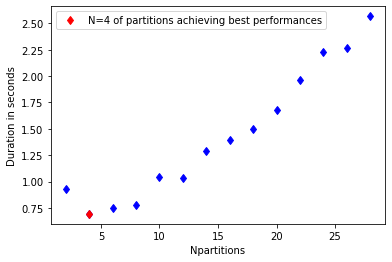

In [58]:
plt.plot(n,duration,"db");
plt.xlabel("Npartitions");
plt.ylabel("Duration in seconds");
plt.plot(min_partiz, min(duration), "dr", label="N={} of partitions achieving best performances".format(min_partiz));
plt.legend();

In [51]:
# necessariamente in questo caso bisogna inizialmente settare gli indici del dask dataframe uguali alle orbite in modo che l'assegnazione
# della nuova colonna t0 tramite la series s che ha come indici proprio le orbite vada a buon fine. Dask è molto più schizzinoso di pandas 
# e quando gli indici di due series non corrispondono allora restituisce un errore mentre pandas ne fa un'inferenza vedendo a quale colonna 
# somigliano gli indici di s e cioè le orbit, assegnando dunque alla colonna t0 righe in base a quali siano le loro orbite e non per forza gli
# indici

s = d5.loc[d5['chan'] == 128, ['orbit', 'time']].set_index('orbit')
# d5['t0'] = s.loc[d5.orbit].time.to_numpy()
# d5.compute()
# s.loc[d5.orbit].time.to_numpy()
# s.compute()
# d5['t0'] = s.loc[d5.set_index('orbit').index].time
d5 = d5.set_index('orbit')
d5['t0'] = s.loc[d5.index].time

In [52]:
# poichè ci interessa tenere le orbite come una colonna del dataframe distinta resetto quanto fatto prima mantenendo però la nuova colonna t0 
d5 = d5.reset_index()

In [53]:
# rimuovo gli scintillatori, che non possono essere piazzati in nessuna colonna in particolare
# NON SOLO QUELLI! Ci sono canali spuri ancora al di sopra
#df2.loc[df2['chan'] == 128] = None  # non basta
d5 = d5[d5['chan'] < 128]

In [54]:
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}

In [55]:
# assegno la camera
d5['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)
tipi2 = tipi
tipi2['chamber'] = 'u1'
d6 = d5.astype(tipi2)
# poichè le assegnazioni con gli oggetti di dask non si possono fare se come indici non sono forniti array e non dask promises costruisco una 
# lista di array booleani che rappresentano le condizioni per attribuire alle opportune righe le giuste chambers
masks=[((d6["fpga"]==0)&(d6["chan"]<64)),
       ((d6["fpga"]==0)&(d6["chan"]>63)),
       ((d6["fpga"]==1)&(d6["chan"]<64)),
       ((d6["fpga"]==1)&(d6["chan"]>63))]

for i,mask in enumerate(masks):
    d6["chamber"]=d6["chamber"].mask(mask,i)

In [56]:
#add layer column
#contando dal basso però partendo da uno non da zero 
d6['layer']=d6["chan"]%4
d6['layer'] = d6['layer'].replace({0:3, 3:0}) # 2:2, 1:1

# NELL ORIGINALE NELLA FUNZIONE REPLACE C'ERA INPLACE=TRUE, SU DASK NON E' SUPPORTATO PERTANTO E' NECESSARIO ASSEGNARE QUELLO CHE ABBIAMO 
# CALCOLATO CON REPLACE ALLA COLONNA CHE VOGLIAMO MODIFICARE (IN QUESTO CASO D6['LAYER'])

d6['layer'] += 1
# #add cell column
# d6["cell"]=d6["chan"]%64

#SAPPIAMO CHE QUESTA COLONNA CELL E' INUTILE 

In [147]:
d6.compute()

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer
0,1118948,27,878,91,1,2,21972.500000,22030.833333,3,1
1,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2
2,1118948,13,891,108,0,2,22285.833333,22030.833333,1,4
3,1118948,20,890,105,0,2,22266.666667,22030.833333,1,2
4,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
624,10515923,17,2877,42,1,2,71939.166667,71715.833333,2,3
625,10515923,11,2879,43,1,2,71984.166667,71715.833333,2,1
626,10515923,24,2875,107,0,2,71895.000000,71715.833333,1,1
627,10515923,20,2878,37,0,2,71966.666667,71715.833333,0,2


In [57]:
# non funziona niente qua sopra, facciamo alla vecchia maniera
def stesso_layer(gruppo) :
    if gruppo['layer'].nunique() == len(gruppo) :
        return gruppo
    else :
        return None 

d7 = d6.groupby(['orbit', 'chamber']).apply(stesso_layer, meta = [('orbit', 'u4'), ('tdc', 'u1'), ('bx', 'u2'), ('chan', 'u2'), 
                                                       ('fpga', 'u1'), ('head', 'u1'), ('time', 'u2'), ('t0', 'u2'), ('chamber', 'u1'), 
                                                       ('layer', 'u1')]).dropna().reset_index(drop = True)
#d7.compute()

In [58]:
# TRASLAZIONE DELLA COLONNA DEI CHAN DI 64 PER QUELLI CHE SONO > 63

# def traslazione_chan(x):
#     if x > 63: x -= 64
# d7['chan'].apply(traslazione_chan, meta = [('orbit', 'u4'), ('tdc', 'u1'), ('bx', 'u2'), ('chan', 'u2'), ('fpga', 'u1'), 
#                                    ('head', 'u1'), ('time', 'u2'), ('t0', 'u2'), ('chamber', 'u1'), ('layer', 'u1'), ('cell', 'u1')]).compute()
d7['chan'] = d7['chan'].mask((d7['chan'] > 63), other = d7['chan'] - 64)
#d7.compute()

In [59]:
f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])
# temp = d7['layer'].apply(f, meta=[('orbit', 'u4'), ('tdc', 'u1'), ('bx', 'u2'), ('chan', 'u2'), ('fpga', 'u1'), ('head', 'u1'), ('time', 'u2'), ('t0', 'u2'), ('chamber', 'u1'), ('layer', 'u1'), ('cell', 'u1')])

# d7["column"] = ((d7['chan'] + f(d7["layer"])) / 4)

# d7.compute()

# IL PROCEDIMENTO CHE ADOTTIAMO PER APPLICARE QUESTE OPERAZIONI ALLE RIGHE AVENTI BEN PRECISI VALORI DI LAYER E' IL SEGUENTE:
# LA FUNZIONE BARYCENTRIC INTERPOLATOR E' UN BEL MODO PER MAPPARE I VALORI DELLA PRIMA LISTA CHE E' COME PRIMO ARGOMENTO DELLA FUNZIONE 
# A QUELLI DELLA SECONDA CHE E' COME SECONDO ARGOMENTO DELLA STESSA. OSSERVIAMO CHE LE RIGHE DI LAYER UNO E QUATTRO RIMANGONO INVARIATE QUINDI
# SUBISCONO SOLTANTO L'OPERAZIONE CHE VEDIAMO NELLA RIGA COMMENTATA D7['COLUMN'] = (D7['CHAN'] + D7['LAYER']) / . AL CONTRARIO QUANDO I LAYER 
# SONO 2 E 3 LA FUNZIONE F LI SOSTITUISCE CON 3 E 2 RISPETTIVAMENTE. PER MIMARE QUESTO COMPORTAMENTE UTILIZZIAMO LA FUNZIONE MASK CON LE DUE 
# CONDIZIONI D7['LAYER'] == 2 E D7['LAYER'] == 3. QUEST ULTIMA SOSTITUISCE AL VALORE CHE SI TROVA NELLA COLONNA D7['COLUMN'] IL CALCOLO 
# CORRISPONDENTE (D7['CHAN'] + F(D7['LAYER'])) / 4

d7["column"] = ((d7['chan'] + d7["layer"]) / 4)

# maschera per layer 2 
d7['column'] = d7['column'].mask(d7['layer'] == 2, other = (3 + d7['chan'])/4 )
d7['column'] = d7['column'].mask(d7['layer'] == 3, other = (2 + d7['chan'])/4 )

d7['column'] = d7['column'].astype('u1')

In [151]:
d7.compute()

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer,column
0,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2,12
1,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3,12
2,1118948,14,881,44,1,2,22036.666667,22030.833333,2,4,12
3,1118948,18,881,47,1,2,22040.000000,22030.833333,2,1,12
4,1126947,20,2225,47,1,2,55641.666667,55415.000000,3,1,12
...,...,...,...,...,...,...,...,...,...,...,...
643,10461215,8,238,45,1,2,5956.666667,5743.333333,2,2,12
644,10515923,17,2867,41,1,2,71689.166667,71715.833333,2,2,11
645,10515923,29,2868,40,1,2,71724.166667,71715.833333,2,4,11
646,10515923,17,2877,42,1,2,71939.166667,71715.833333,2,3,11


In [60]:
d8 = d7.copy()

In [61]:
centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
# d8["center"] = centers_coords[d7.layer-1,d7.column-1]
d8['center'] = d8['column']*2
d8['center'] = d8['center'].mask(d8['layer'] == 1, other = d8['center'] - 1)
d8['center'] = d8['center'].mask(d8['layer'] == 3, other = d8['center'] - 1)
#d8.compute()

# ATTENZIONE CHE CENTER E' MISURATO IN UNITA' DI DELTA X MEZZI. 
# ABBIAMO RAGIONATO PER QUEI LAYER "TRASLATI" COSI' COME NELLA MASCHERA PRECEDENTE CHE CALCOLA LA COLONNA "COLUMN"

In [62]:
time_offset = np.array([-1.1, 6.4, 0.5, -2.6])

d8['dt'] = d8['time'] - d8['t0'] + 95 #+ dd.from_array(time_offset[d8['layer'] - 1])

for i,to in enumerate(time_offset):
    d8['dt'] = d8['dt'].mask(d8['chamber'] == i, other = d8['dt'] + to) 
    
# d8['dt'] = d8['dt'].mask(d8['chamber'] == 1, other = d8['dt'] - 1.1) 
# d8['dt'] = d8['dt'].mask(d8['chamber'] == 2, other = d8['dt'] + 6.4) 
# d8['dt'] = d8['dt'].mask(d8['chamber'] == 3, other = d8['dt'] - 1.1) 
# d8['dt'] = d8['dt'].mask(d8['chamber'] == 4, other = d8['dt'] - 1.1) 

# 42/2 = 21
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
d8['xr'] = d8['center']*21 + vd*d8['dt']
d8['xl'] = d8['center']*21 - vd*d8['dt']

z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
dz2 = 13/2

d8['z'] = d8['layer']*dz2 

for i,zo in enumerate(z_offset):
    d8['z'] = d8['z'].mask(d8['chamber'] == i, other = d8['z'] + zo) 
    
# d8['z'] = d8['layer']*dz2 + dd.from_array(z_offset[d8['chamber'])

In [155]:
d8.compute()

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z
0,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1048.6
1,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1055.1
2,1118948,14,881,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1061.6
3,1118948,18,881,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1
4,1126947,20,2225,47,1,2,55641.666667,55415.000000,3,1,12,23,319.066667,244.165787,209.834213,1826.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,10461215,8,238,45,1,2,5956.666667,5743.333333,2,2,12,24,308.833333,264.615233,231.384767,1048.6
644,10515923,17,2867,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1048.6
645,10515923,29,2868,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1061.6
646,10515923,17,2877,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1055.1


In [157]:
d8.compute()

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z
0,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1048.6
1,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1055.1
2,1118948,14,881,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1061.6
3,1118948,18,881,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1
4,1126947,20,2225,47,1,2,55641.666667,55415.000000,3,1,12,23,319.066667,244.165787,209.834213,1826.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,10461215,8,238,45,1,2,5956.666667,5743.333333,2,2,12,24,308.833333,264.615233,231.384767,1048.6
644,10515923,17,2867,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1048.6
645,10515923,29,2868,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1061.6
646,10515923,17,2877,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1055.1


In [63]:
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
            s[i] = 0 #np.nan
        else :
            slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
            intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

            s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s

def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [64]:
d9 = d8.copy()
d9 = d9.groupby(['orbit', 'chamber']).apply(solve_ambiguity, meta=[('orbit', 'u4'), ('tdc', 'u1'), ('bx', 'u2'), ('chan', 'u2'), 
                                                                   ('fpga', 'u1'), ('head', 'u1'), ('time', 'f8'), ('t0', 'f8'), 
                                                                   ('chamber', 'u1'), ('layer', 'u1'), ('column', 'u1'),
                                                                   ('center', 'u1'), ('dt', 'f8'), ('xr', 'f8'), ('xl', 'f8'),
                                                                   ('z', 'f8'), ('xb', 'f8')])

#d9.compute()

In [78]:
# PER VISUALIZZARE QUALCHE GRUPPO DI EVENTI CIOE' ALCUNE ORBITE PASSIAMO DEI SOTTO GRUPPI DEL DATAFRAME OTTENUTO A DEI PANDAS DATAFRAME 

In [65]:
df8 = d9.compute()

In [81]:
# FIT LOCALE 

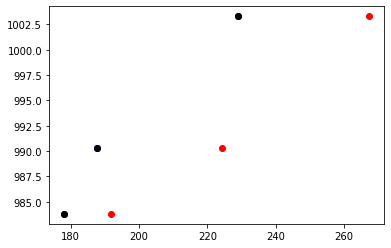

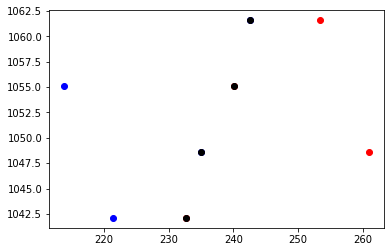

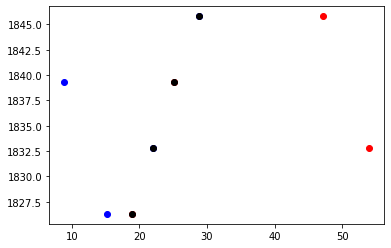

In [66]:
n = 0 # numero orbita da visualizzare
tmp = df8.loc[df8.orbit == df8.orbit.unique()[n]].sort_values('chamber')

# voglio una riga per camera, ciascuna contenente tutte le hits di quella camera

# vxr = tmp.xr.to_numpy().reshape((-1, 4))
# vxl = tmp.xl.to_numpy().reshape((-1, 4))
# vxb = tmp.xb.to_numpy().reshape((-1, 4))
# vz = tmp.z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

for ch in tmp.chamber.unique() :
    vxr = tmp[tmp.chamber == ch].xr
    vxl = tmp[tmp.chamber == ch].xl
    vxb = tmp[tmp.chamber == ch].xb
    vz = tmp[tmp.chamber == ch].z

    fig, ax = plt.subplots()
    ax.scatter(vxl, vz, c = 'blue')
    ax.scatter(vxr, vz, c = 'red')
    ax.scatter(vxb, vz, c = 'black')

In [82]:
# FIT GLOBALE IN 2D 

***
### Il filtro della vicinanza orizzontale che fine ha fatto? Viene soppiantato dal filtro di non più di una cella attiva per layer? Verificare
***

In [67]:
df2d = df8.copy() # pronti per il fit globale 2D; tolgo la camera 1 che è rilevante solo per quello 3d
df2d = df2d[df2d['chamber'] != 1]
df2d

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1048.6,235.061100
1,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1055.1,240.118233
2,1118948,14,881,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1061.6,242.548267
3,1118948,18,881,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
4,1118948,27,878,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,10515923,20,2878,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,232.8,145.453347
3402,10515923,17,2867,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1048.6,202.296767
3403,10515923,29,2868,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1061.6,200.413767
3404,10515923,17,2877,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1055.1,202.153233


In [68]:
# da df2d devo togliere le orbite che non abbiano almeno 2 camere (senza contare 1 che ho tolto, ovviamente)
df2d = df2d[df2d.orbit.isin(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1])]
df2d

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1048.6,235.061100
1,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1055.1,240.118233
2,1118948,14,881,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1061.6,242.548267
3,1118948,18,881,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
4,1118948,27,878,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,10515923,20,2878,37,0,2,71966.666667,71715.833333,0,2,10,20,344.733333,182.546653,145.453347,232.8,145.453347
3402,10515923,17,2867,41,1,2,71689.166667,71715.833333,2,2,11,22,68.833333,209.703233,202.296767,1048.6,202.296767
3403,10515923,29,2868,40,1,2,71724.166667,71715.833333,2,4,11,22,103.833333,211.586233,200.413767,1061.6,200.413767
3404,10515923,17,2877,42,1,2,71939.166667,71715.833333,2,3,11,21,318.833333,202.153233,167.846767,1055.1,202.153233


In [77]:
@njit
def fit(z, x) : # ricorda: nel nostro fit (rispetto a wikipedia) si ha x -> z (variabile fissa/senza errore/senza osservazioni da confrontare con predizioni) e y -> x (tutto il contrario dell'altra)
    if ((z - z.mean())**2).sum() == 0 :
        print('AAAAAAAAAAA')
        print(z)
    slope = ((z - z.mean())*(x - x.mean())).sum() / ((z - z.mean())**2).sum()
    intercept = x.mean() - slope * z.mean()
    return slope, intercept # geometricamente queste due sono "sbagliate" ma filosoficamente e numericamente no!
    # questi due parametri soddisfano l'equazione x = slope*z+intercept visto quanto detto sopra su x, y e z

In [70]:
df2d[df2d.orbit == df2d.orbit.unique()[0]] # nota che i valori di z sono già globali!!

,orbit,tdc,bx,chan,fpga,head,time,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,1118948,1,887,45,1,2,22175.833333,22030.833333,2,2,12,24,240.500000,260.938900,235.061100,1048.6,235.061100
1,1118948,5,887,46,1,2,22179.166667,22030.833333,2,3,12,23,243.833333,240.118233,213.881767,1055.1,240.118233
2,1118948,14,881,44,1,2,22036.666667,22030.833333,2,4,12,24,101.333333,253.451733,242.548267,1061.6,242.548267
3,1118948,18,881,47,1,2,22040.000000,22030.833333,2,1,12,23,104.666667,232.631067,221.368933,1042.1,232.631067
4,1118948,27,878,27,1,2,21972.500000,22030.833333,3,1,7,13,34.066667,18.832787,15.167213,1826.3,18.832787
5,1118948,12,889,25,1,2,22235.000000,22030.833333,3,2,7,14,296.566667,53.955287,22.044713,1832.8,22.044713
6,1118948,12,884,24,1,2,22110.000000,22030.833333,3,4,7,14,171.566667,47.230287,28.769713,1845.8,28.769713
7,1118948,17,883,26,1,2,22089.166667,22030.833333,3,3,7,13,150.733333,25.109453,8.890547,1839.3,25.109453


In [71]:
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

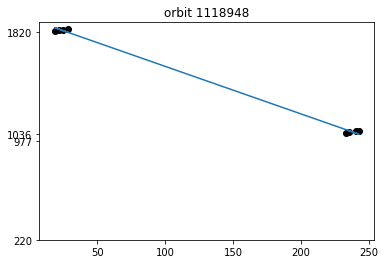

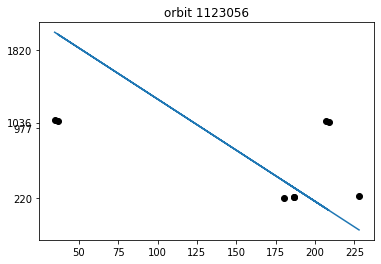

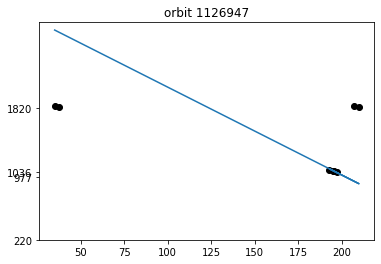

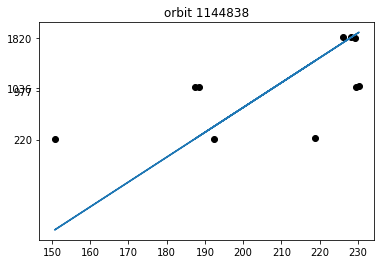

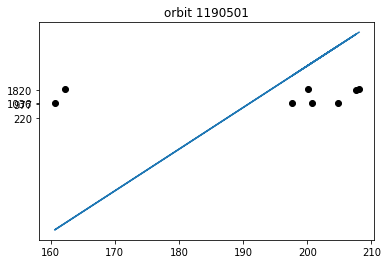

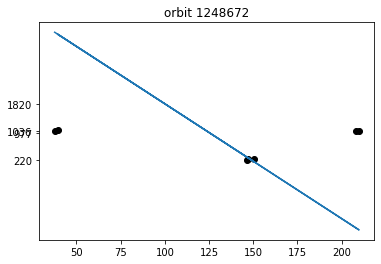

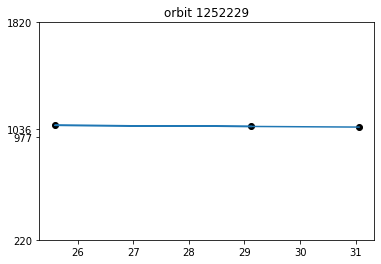

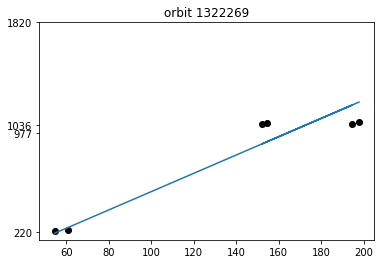

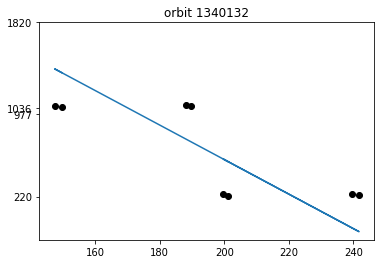

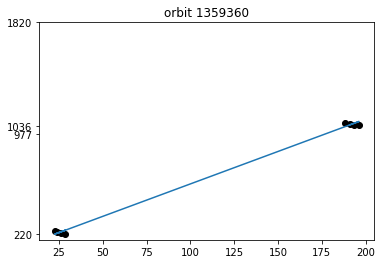

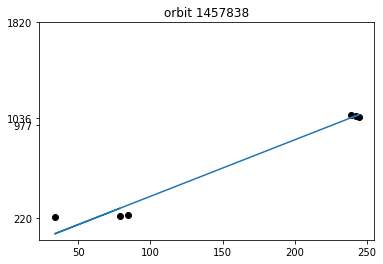

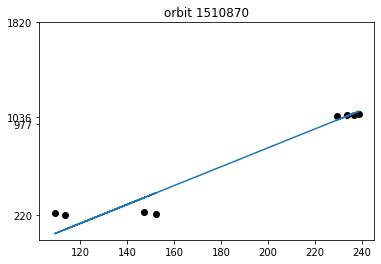

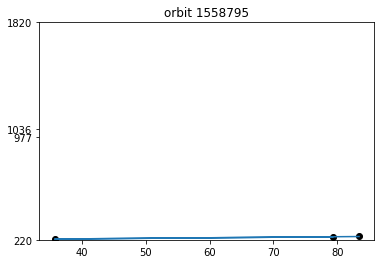

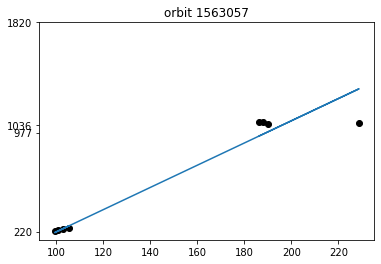

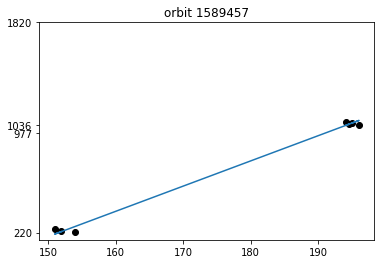

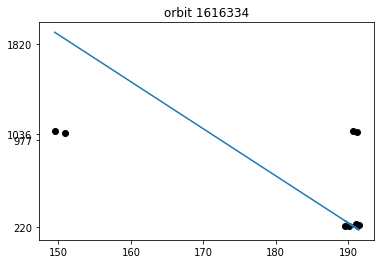

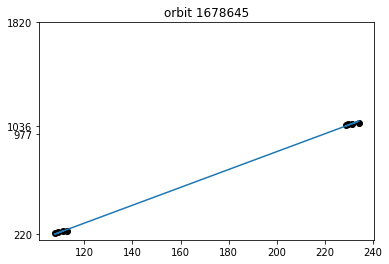

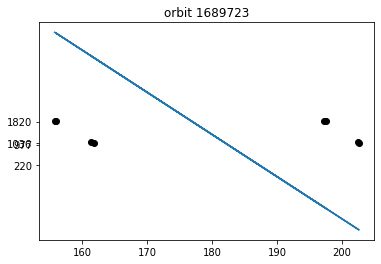

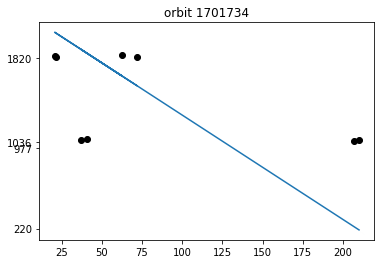

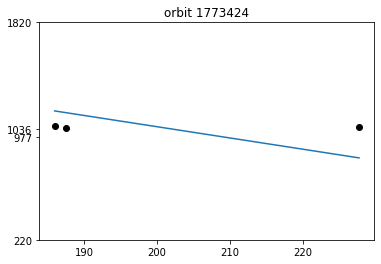

In [72]:
for i in range(20) :
    plot_global_fit(df2d[df2d.orbit == df2d.orbit.unique()[i]])

In [73]:
df2d.groupby(['orbit', 'chamber','layer']).nunique()

tdc  bx  chan  fpga  head  time  t0  column  center  \
orbit    chamber layer                                                        
1118948  2       1        1   1     1     1     1     1   1       1       1   
                 2        1   1     1     1     1     1   1       1       1   
                 3        1   1     1     1     1     1   1       1       1   
                 4        1   1     1     1     1     1   1       1       1   
         3       1        1   1     1     1     1     1   1       1       1   
...                     ...  ..   ...   ...   ...   ...  ..     ...     ...   
10515923 0       4        1   1     1     1     1     1   1       1       1   
         2       1        1   1     1     1     1     1   1       1       1   
                 2        1   1     1     1     1     1   1       1       1   
                 3        1   1     1     1     1     1   1       1       1   
                 4        1   1     1     1     1     1   1       1       1   

                        dt  xr  xl  z  xb  
orbit    chamber layer                     
1118948  2       1       1   1   1  1   1  
                 2       1   1   1  1   1  
                 3       1   1   1  1   1  
                 4       1   1   1  1   1  
         3       1       1   1   1  1   1  
...                     ..  ..  .. ..  ..  
10515923 0       4       1   1   1  1   1  
         2       1       1   1   1  1   1  
                 2       1   1   1  1   1  
                 3       1   1   1  1   1  
                 4       1   1   1  1   1  

[2739 rows x 14 columns]

## Serve la vicinanza orizzontale
Intanto però vediamo se i residui possano essere usati in tal senso

In [112]:
np.array(df2d.loc[df2d['orbit'] > 3149859]['z'][:4])

array([1061.6, 1048.6, 1042.1, 1055.1])

In [119]:
((np.array(df2d.loc[df2d['orbit'] > 3149859]['z'][:4]) - np.array(df2d.loc[df2d['orbit'] > 3149859]['z'][:4]).mean())**2).sum()

211.25

In [78]:
def residui(gruppo) :
    slope, intercept = fit(gruppo['z'].to_numpy(), gruppo['xb'].to_numpy())
    gruppo['residui'] = gruppo['xb'] - slope*gruppo['z']-intercept # x osservato - x predetto
#     print(gruppo['orbit'].iloc[0])
    return gruppo 

df2d_2 = df2d.groupby('orbit').apply(residui).reset_index(drop = True)
df2d_2

AAAAAAAAAAA
[245.8]


ZeroDivisionError: division by zero

4.053874453837722e-13


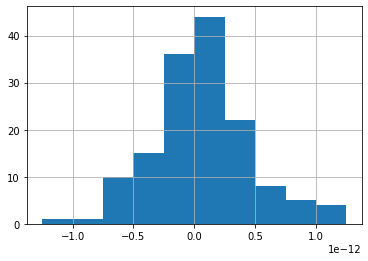

In [89]:
s = df2d_2.groupby('orbit').apply(lambda gruppo: gruppo.residui.sum())
print(s.std())
s.hist();
# assolutamente inutile (sono tutti 0 stando ai float ecc.), il che conferma che effettivamente quella di somma dei residui = 0 è una identità soddisfatta sempre per via di come calcolo alpha e beta, non eliminata da rumore o eventuali errori casuali/sistematici

In [92]:
s1 = df2d_2.groupby('chamber').apply(lambda gruppo: gruppo.residui)
s1#.hist();

chamber      
0        8       -0.476486
         9       -2.133512
         10       1.230708
         11       1.451406
         39      -0.877023
                   ...    
3        1078    -3.861246
         1079     2.913926
         1084    11.879557
         1085    -6.123279
         1086    -5.599364
Name: residui, Length: 1101, dtype: float64

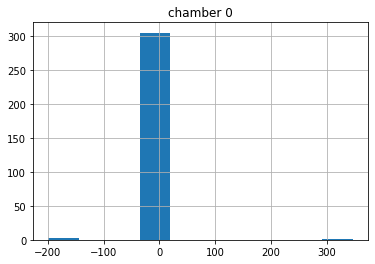

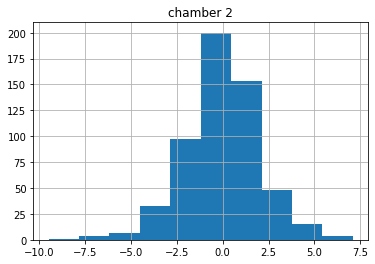

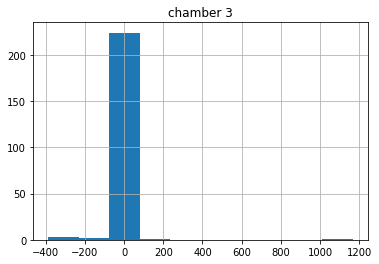

In [113]:
for i in [0, 2, 3] :
    plt.figure();
    s1[i].hist();
    plt.title(f'chamber {i}')

## Chamber 2 nell'istogramma precedente: praticamente come al caruso. Camere 0 e 3: sballate dal non aver tolto quelli che non rispettano la vicinanza orizzontale!
In ogni caso questo modo di procedere è effettivamente migliore del precedente, visto che sommando i residui relativi solo ad una camera (quindi non tutti) non ottengo necessariamente 0, anzi in generale tutt'altro!

P.S. ovviamente la camera 1 è stata esclusa da questo discorso

In [111]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s1[i].std()) # e infatti le camere sballate hanno sigma enormi

std ch. 0 -> 24.595437243122237
std ch. 2 -> 2.0673307967973304
std ch. 3 -> 89.9683593078609


In [104]:
# e se provassi ad eliminare la spazzatura ricorrendo ai residui stessi?
df2d_3 = df2d_2[df2d_2.residui.abs() < 15] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_3

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
1096,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673,2.164219
1097,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827,-1.656821
1098,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-0.317189
1099,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767,-0.210408


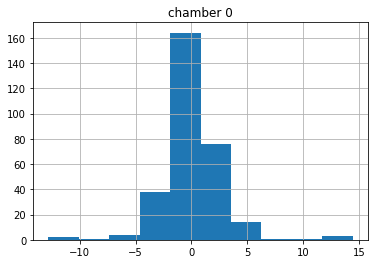

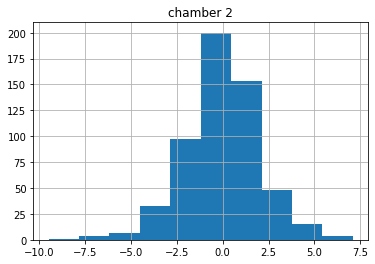

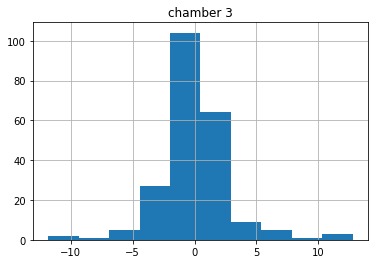

In [109]:
s2 = df2d_3.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s2[i].hist();
    plt.title(f'chamber {i}');

In [112]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s2[i].std())

std ch. 0 -> 2.727777163142205
std ch. 2 -> 2.0673307967973304
std ch. 3 -> 2.893064617347618


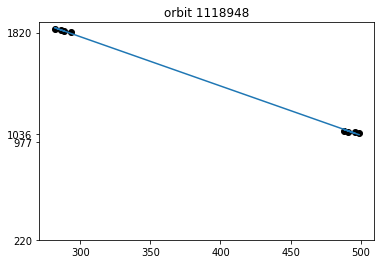

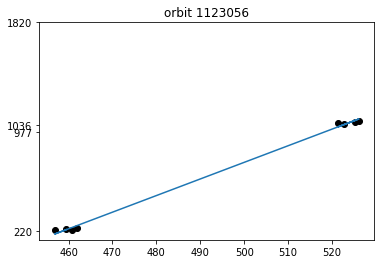

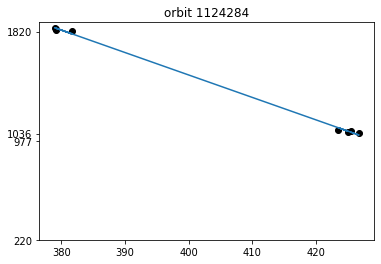

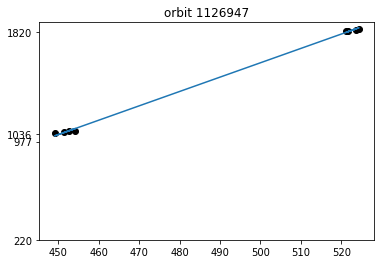

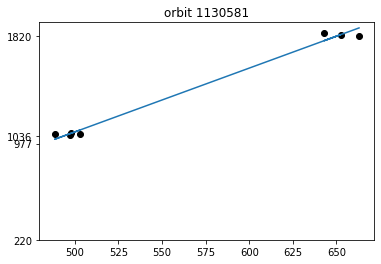

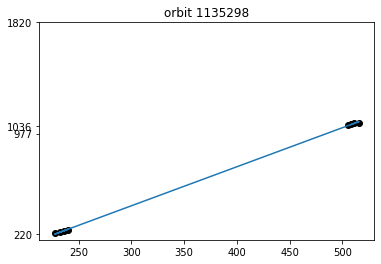

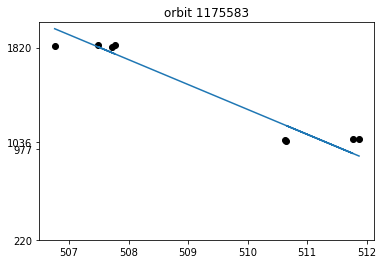

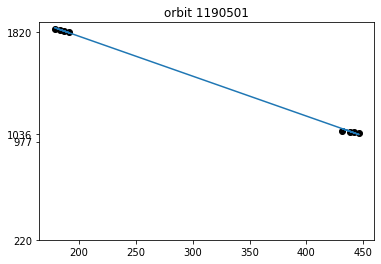

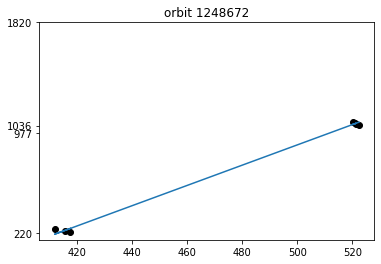

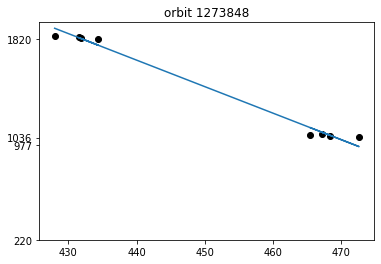

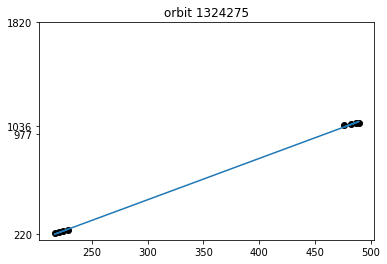

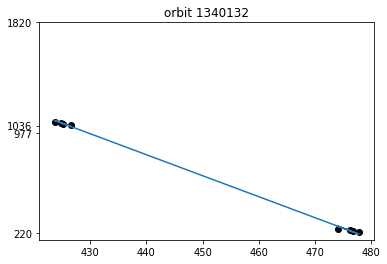

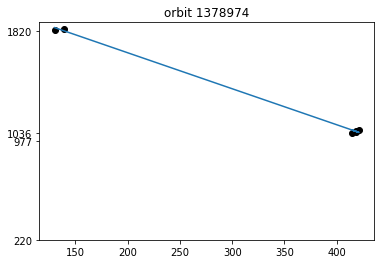

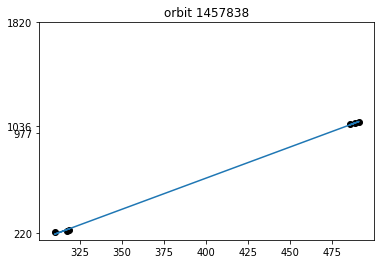

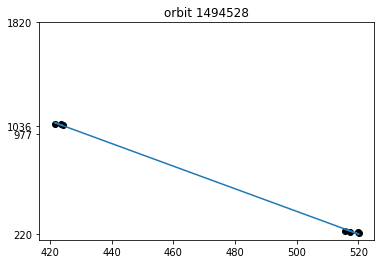

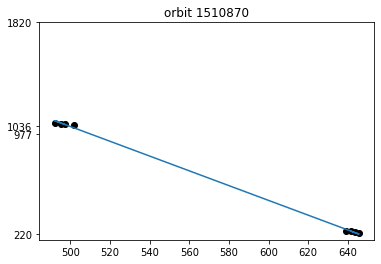

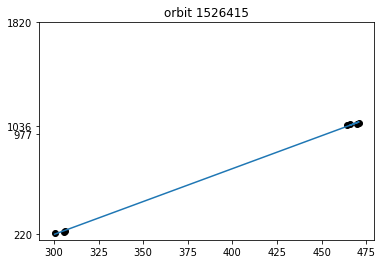

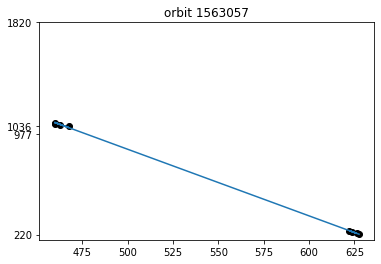

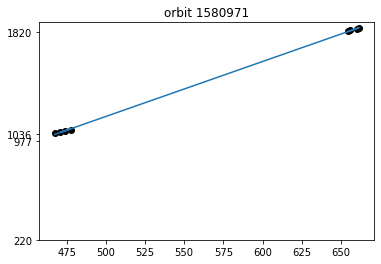

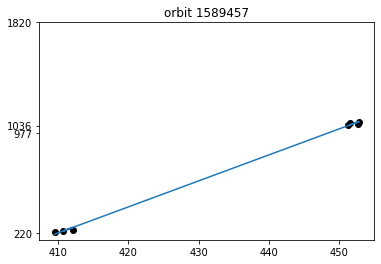

In [114]:
for i in range(20) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]])

In [115]:
df2d_4 = df2d_2[df2d_2.residui.abs() < 10] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_4

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
1096,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673,2.164219
1097,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827,-1.656821
1098,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-0.317189
1099,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767,-0.210408


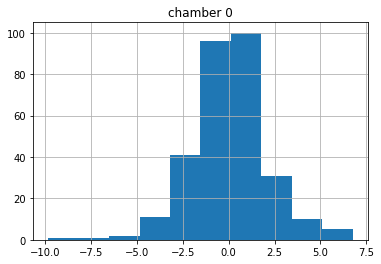

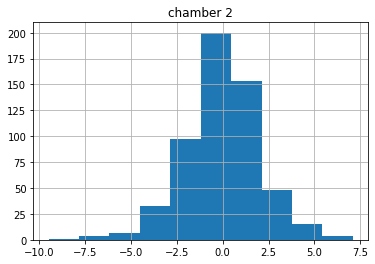

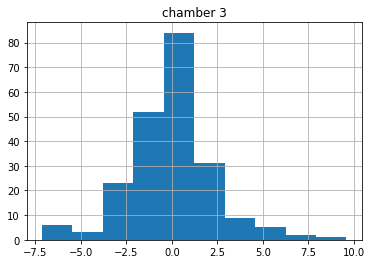

In [116]:
s3 = df2d_4.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s3[i].hist();
    plt.title(f'chamber {i}');

In [117]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s3[i].std())

std ch. 0 -> 2.079295401663555
std ch. 2 -> 2.0673307967973304
std ch. 3 -> 2.279331187634145


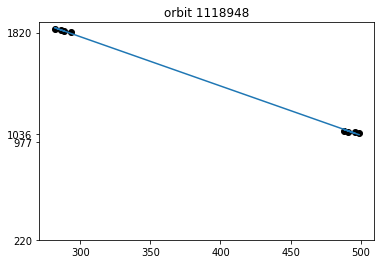

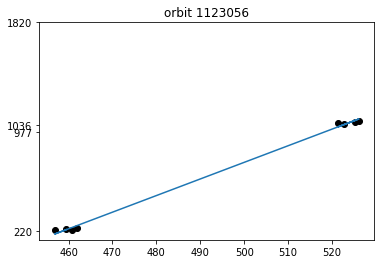

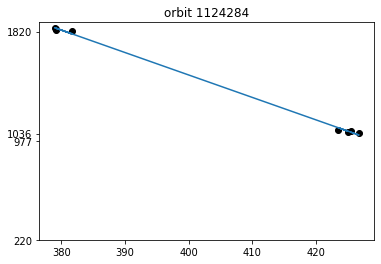

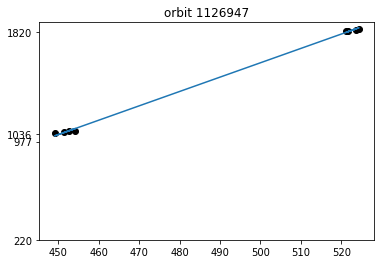

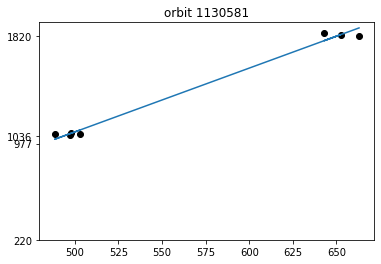

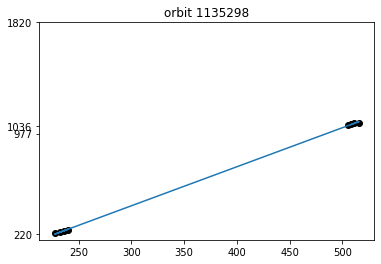

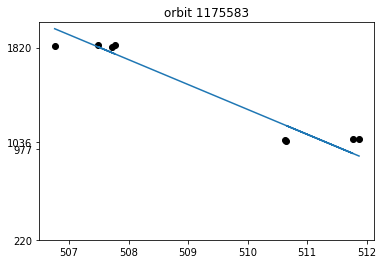

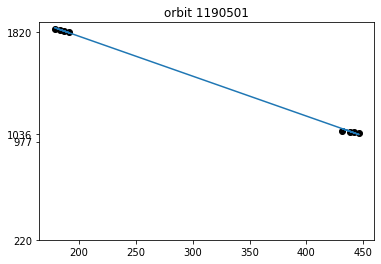

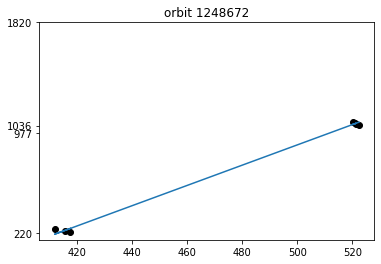

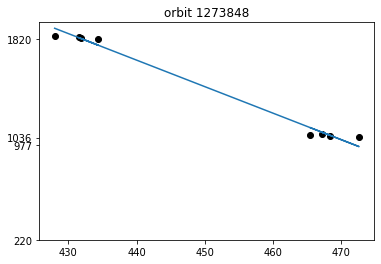

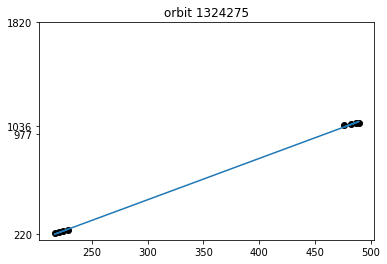

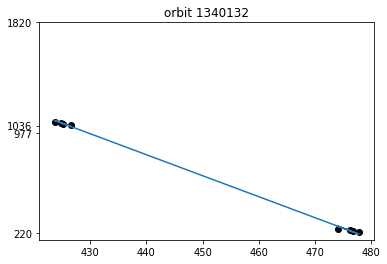

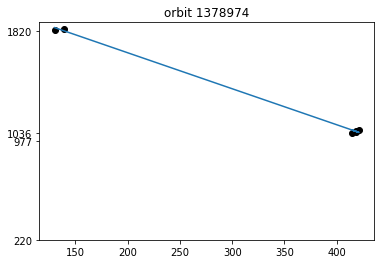

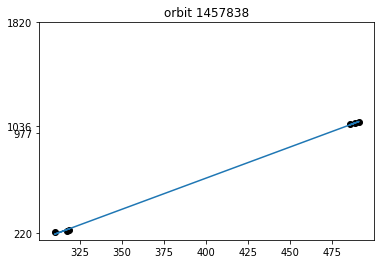

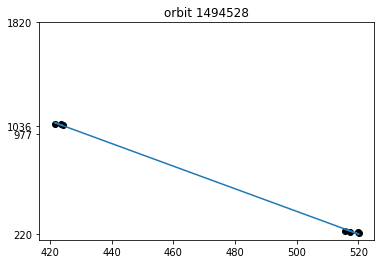

In [119]:
for i in range(15) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]]) # ancora passa quella disgraziata, grrr

In [72]:
client.close()

#### Prova con la funzione di lettura e scrittura nella bag senza approccio funzionale

In [53]:
%%time
b1 = db.from_sequence(data_names).map(load_from_file1).flatten()
b1.take(5)
# con più righe prese si vede che impiega di più rispetto ad invece utilizzare due funzioni separate probabilmente perchè questi processi 
# verranno eseguiti si in parallelo ma anche in modo concorrenziale uno contemporaneamente all'altro. In questo caso invece sia il load 
# che la decodifica dei dati si trovano nella stessa funzione e quindi vengono eseguiti per ogni partizione in maniera sequenziale

CPU times: user 27.3 ms, sys: 1.44 ms, total: 28.7 ms
Wall time: 92 ms


(array([         0,          0, 4079645633,        100,          1,
                 1], dtype=uint32),
 array([         2,       4064, 4079645602,        100,          1,
                 0], dtype=uint32),
 array([        23,       1476, 4079645568,        100,          1,
                 4], dtype=uint32),
 array([        16,        653, 4079645568,        100,          1,
                 5], dtype=uint32),
 array([         2,       2922, 3387200947,         75,          0,
                 2], dtype=uint32))

In [22]:
def read_from_file(file): return np.fromfile(file, dtype = '<u8')

# comportamento misterioso senza flatten 
bg = db.from_sequence(data_names).map(read_from_file)

#### Prova con dataframe pandas

In [30]:
m = [*(np.fromfile(file, dtype = '<u8') for file in data_names1)]
fin = []
for mi in m:   
    mat = np.zeros((mi.shape[0], 6), dtype = "u4")
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61
    fin.append(mat)

In [31]:
fin = np.concatenate(fin)

In [32]:
df = pd.DataFrame(fin, columns = ['tdc', 'bx', 'orbit', 'chan', 'fpga', 'head'])

In [34]:
df = df[(df['head']==2)]

In [35]:
%%time 

def cut(group): 
    if group.shape[0] < 15 and group.shape[0] > 3 : return group 
    else : return None 
    
df1=df.groupby(['orbit'],group_keys=False)\
                 .apply(cut)\
                 .dropna()\
                 .reset_index()\
                 .drop(['index'],axis=1)

CPU times: user 1min 6s, sys: 5.82 s, total: 1min 12s
Wall time: 1min 6s


In [36]:
len(df1)/len(df)

0.36005124206843336

In [114]:
(((df1['fpga'] == 1) & (df1['chan'] == 128)).values)[(((df1['fpga'] == 1) & (df1['chan'] == 128)).values)==True]
# intanto significa che ci sono scintillatori che verificano questa condizione e prendo ad esempio i primi cinque 

In [37]:
indici = ((df1['fpga'] == 1) & (df1['chan'] == 128))[((df1['fpga'] == 1) & (df1['chan'] == 128))==True].index
# questi sono gli indici delle orbite di ciascun gruppo in cui un evento è considerato accettabile 

In [38]:
len(indici)
# è diverso da len(df3)

697

In [39]:
orbite_buone = df1.orbit[indici].values

In [40]:
# adesso devo considerare tutte le operazione che farò sui gruppi di orbite in quanto sono gli eventi che stiamo considerando. Dunque i 
# successivi filtri servono per filtrare i gruppi di hits non le singole righe del dataframe 

fpga1_chan1 = orbite_buone
# queste sono le orbits corrispondenti a fpga = 1 quindi se faccio .index e poi .isin dovrei aver filtrato il 
# dataframe. Visto che le orbite per ogni gruppo sono uguale praticamente sto selezionando quei gruppi che hanno fpga == 1

df3 = df1[df1['orbit'].isin(fpga1_chan1)]

In [48]:
# # adesso il filtro analogo al precedente ma con gli scintillatori 128

# chan2 = df2[df2['chan'] == 128].orbit.values
# df3 = df2[df2['orbit'].isin(chan2)]
# già fatto tutto insieme prima 


# vorrei però confrontare se ottengo lo stesso risultato applicando i due filtri consecutivamente oppure uno dopo l'altro
fpga1 = df1[df1['fpga'] == 1].orbit.values
dfconfronto = df1[df1['orbit'].isin(fpga1)]

chan2 = dfconfronto[dfconfronto['chan'] == 128].orbit.values
dfconfronto1 = dfconfronto[dfconfronto['orbit'].isin(chan2)]


In [58]:
if np.any(df3 == dfconfronto1): print("I due filtri possono essere eseguiti anche sequenzialmente uno dopo l'altro anzichè pensarli in contemporanea")

I due filtri possono essere eseguiti anche sequenzialmente uno dopo l'altro anzichè pensarli in contemporanea


In [59]:
# df3 = df3.reset_index().drop('index', axis=1)
# per resettare gli indici e droppare quelli che otteniamo introducendo una nuova colonna "index". Serve soltanto per il caso sequenziale 
# poichè nel dask dataframe non ci importa come sono ordinate le hits tramite gli indici

In [34]:
print('Il preprocessing di fpga, chan e head conduce ad un dataframe il {} % più piccolo di quello iniziale '.format((1-len(df3)/len(df))*100))
# rimane dunque lo 0.3 % del dataframe iniziale con un numero unico di eventi pari a 
print('Il numero unico di eventi è uguale a', len(df3.groupby('orbit').nunique()))

Il preprocessing di fpga, chan e head conduce ad un dataframe il 99.67291097153738 % più piccolo di quello iniziale 
Il numero unico di eventi è uguale a 695


In [41]:
df3._is_copy = None 
# trucco ihih perchè df3 è una copia di df1 e lui ne tiene conto in questo modo segnalando warning

In [42]:
# adesso aggiungo le colonne del tempo e delle camere:

# 25 ∗ (ORBIT ∗ 3564 + BX + TDC/30) per il tempo 
df3['t'] = 25*df3['bx'] + 25*df3['tdc']/30
# df3['time'] = 25 * ((df3['orbit'] * 3564) + df3['bx'] + (df3['tdc']/30))

In [43]:
# rimuovo le orbite con più scintillatori
v1, v2 = np.unique(df3.loc[df3.chan == 128, 'orbit'], return_counts = True)
df3.loc[df3.orbit.isin(v1[v2 > 1])] = None
df3 = df3.dropna()
df3

,tdc,bx,orbit,chan,fpga,head,t
1784,27.0,878.0,1118948.0,91.0,1.0,2.0,21972.500000
1785,8.0,882.0,1118948.0,107.0,0.0,2.0,22056.666667
1786,18.0,881.0,1118948.0,47.0,1.0,2.0,22040.000000
1787,12.0,884.0,1118948.0,88.0,1.0,2.0,22110.000000
1788,7.0,881.0,1118948.0,128.0,1.0,2.0,22030.833333
...,...,...,...,...,...,...,...
892522,17.0,2877.0,10515923.0,42.0,1.0,2.0,71939.166667
892523,11.0,2879.0,10515923.0,43.0,1.0,2.0,71984.166667
892524,24.0,2875.0,10515923.0,107.0,0.0,2.0,71895.000000
892525,20.0,2878.0,10515923.0,37.0,0.0,2.0,71966.666667


In [44]:
s = df3.loc[df3['chan'] == 128, ['orbit', 't']].set_index('orbit')
df3['t0'] = s.loc[df3.orbit].t.to_numpy()

df3

,tdc,bx,orbit,chan,fpga,head,t,t0
1784,27.0,878.0,1118948.0,91.0,1.0,2.0,21972.500000,22030.833333
1785,8.0,882.0,1118948.0,107.0,0.0,2.0,22056.666667,22030.833333
1786,18.0,881.0,1118948.0,47.0,1.0,2.0,22040.000000,22030.833333
1787,12.0,884.0,1118948.0,88.0,1.0,2.0,22110.000000,22030.833333
1788,7.0,881.0,1118948.0,128.0,1.0,2.0,22030.833333,22030.833333
...,...,...,...,...,...,...,...,...
892522,17.0,2877.0,10515923.0,42.0,1.0,2.0,71939.166667,71715.833333
892523,11.0,2879.0,10515923.0,43.0,1.0,2.0,71984.166667,71715.833333
892524,24.0,2875.0,10515923.0,107.0,0.0,2.0,71895.000000,71715.833333
892525,20.0,2878.0,10515923.0,37.0,0.0,2.0,71966.666667,71715.833333


In [45]:
# rimuovo gli scintillatori, che non possono essere piazzati in nessuna colonna in particolare
# NON SOLO QUELLI! Ci sono canali spuri ancora al di sopra
#df2.loc[df2['chan'] == 128] = None  # non basta
df3.loc[df3['chan'] > 127] = None 
df3.dropna(inplace = True)
df3

,tdc,bx,orbit,chan,fpga,head,t,t0
1784,27.0,878.0,1118948.0,91.0,1.0,2.0,21972.500000,22030.833333
1785,8.0,882.0,1118948.0,107.0,0.0,2.0,22056.666667,22030.833333
1786,18.0,881.0,1118948.0,47.0,1.0,2.0,22040.000000,22030.833333
1787,12.0,884.0,1118948.0,88.0,1.0,2.0,22110.000000,22030.833333
1789,14.0,881.0,1118948.0,44.0,1.0,2.0,22036.666667,22030.833333
...,...,...,...,...,...,...,...,...
892522,17.0,2877.0,10515923.0,42.0,1.0,2.0,71939.166667,71715.833333
892523,11.0,2879.0,10515923.0,43.0,1.0,2.0,71984.166667,71715.833333
892524,24.0,2875.0,10515923.0,107.0,0.0,2.0,71895.000000,71715.833333
892525,20.0,2878.0,10515923.0,37.0,0.0,2.0,71966.666667,71715.833333


In [46]:
# assegno la camera
df3['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)
tipi2 = tipi
tipi2['chamber'] = 'u1'
df3 = df3.astype(tipi2)

df3.loc[(df3['fpga'] == 0) & (df3['chan'] < 64), 'chamber'] = 0
df3.loc[(df3['fpga'] == 0) & (df3['chan'] > 63), 'chamber'] = 1
df3.loc[(df3['fpga'] == 1) & (df3['chan'] < 64), 'chamber'] = 2
df3.loc[(df3['fpga'] == 1) & (df3['chan'] > 63), 'chamber'] = 3

df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber
1784,27,878,1118948,91,1,2,21972.500000,22030.833333,3
1785,8,882,1118948,107,0,2,22056.666667,22030.833333,1
1786,18,881,1118948,47,1,2,22040.000000,22030.833333,2
1787,12,884,1118948,88,1,2,22110.000000,22030.833333,3
1789,14,881,1118948,44,1,2,22036.666667,22030.833333,2
...,...,...,...,...,...,...,...,...,...
892522,17,2877,10515923,42,1,2,71939.166667,71715.833333,2
892523,11,2879,10515923,43,1,2,71984.166667,71715.833333,2
892524,24,2875,10515923,107,0,2,71895.000000,71715.833333,1
892525,20,2878,10515923,37,0,2,71966.666667,71715.833333,0


In [47]:
#add layer column
#contando dal basso però partendo da uno non da zero 
df3["layer"]=df3["chan"]%4
df3['layer'].replace({0:3, 3:0}, inplace = True) # 2:2, 1:1
df3['layer'] += 1
#add cell column
# df3["cell"]=df3["chan"]%64
# df3

In [114]:
# #drop events with multiple hits on the same layer
# def multiple_layers(group):
    
#     #obtain all ordered (chamber,layer) pairs
#     pairs=pd.Series([(a,b) for a,b in zip(group["chamber"],group["layer"])]) #might be slow
    
#     if pairs.duplicated().any(): return None
#     else: return group

# df4=df3.groupby("orbit").apply(multiple_layers).reset_index(drop=True)

In [48]:
# non funziona niente qua sopra, facciamo alla vecchia maniera
def stesso_layer(gruppo) :
    if gruppo['layer'].nunique() == len(gruppo) :
        return gruppo
    else :
        return None 

df4 = df3.groupby(['orbit', 'chamber']).apply(stesso_layer).dropna().reset_index(drop = True)

In [49]:
df4

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,1
1,20,890,1118948,105,0,2,22266.666667,22030.833333,1,2
2,13,891,1118948,108,0,2,22285.833333,22030.833333,1,4
3,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1
4,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4
...,...,...,...,...,...,...,...,...,...,...
5571,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2
5572,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2
5573,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4
5574,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3


In [50]:
df4.loc[df4["chan"] > 63,"chan"] -= 64

f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])
df4["column"] = ((df4['chan'] + f(df4["layer"])) / 4).astype(np.uint8)
df4

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11
1,20,890,1118948,41,0,2,22266.666667,22030.833333,1,2,11
2,13,891,1118948,44,0,2,22285.833333,22030.833333,1,4,12
3,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12
4,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12
...,...,...,...,...,...,...,...,...,...,...,...
5571,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10
5572,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11
5573,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11
5574,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11


In [51]:
centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
df4["center"] = centers_coords[df4.layer-1,df4.column-1] 
df4

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22
1,20,890,1118948,41,0,2,22266.666667,22030.833333,1,2,11,21
2,13,891,1118948,44,0,2,22285.833333,22030.833333,1,4,12,23
3,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,24
4,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,23
...,...,...,...,...,...,...,...,...,...,...,...,...
5571,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,19
5572,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,21
5573,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,21
5574,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,22


In [52]:
time_offset = np.array([-1.1, 6.4, 0.5, 2.6])

df4['dt'] = df4['t'] - df4['t0'] + 95 + time_offset[df4['layer'] - 1]
df4

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,119.733333
1,20,890,1118948,41,0,2,22266.666667,22030.833333,1,2,11,21,337.233333
2,13,891,1118948,44,0,2,22285.833333,22030.833333,1,4,12,23,352.600000
3,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,24,103.066667
4,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,23,103.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,19,352.233333
5572,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,21,74.733333
5573,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,21,105.933333
5574,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,22,318.833333


In [53]:
# 42/2 = 21
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
df4['xr'] = df4['center']*21 + vd*df4['dt']
df4['xl'] = df4['center']*21 - vd*df4['dt']

z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
dz2 = 13/2

df4['z'] = df4['layer']*dz2 + z_offset[df4['layer'] - 1]
df4

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt,xr,xl,z
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,119.733333,468.441653,455.558347,226.3
1,20,890,1118948,41,0,2,22266.666667,22030.833333,1,2,11,21,337.233333,459.143153,422.856847,990.3
2,13,891,1118948,44,0,2,22285.833333,22030.833333,1,4,12,23,352.600000,501.969880,464.030120,1845.8
3,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,24,103.066667,509.544987,498.455013,226.3
4,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,23,103.433333,488.564713,477.435287,1845.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,19,352.233333,417.950153,380.049847,990.3
5572,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,21,74.733333,445.020653,436.979347,990.3
5573,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,21,105.933333,446.699213,435.300787,1845.8
5574,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,22,318.833333,479.153233,444.846767,1055.1


In [54]:
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
            s[i] = 0 #np.nan
        else :
            slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
            intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

            s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s

def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [55]:
df5 = df4.copy()
df5 = df5.groupby(['orbit', 'chamber']).apply(solve_ambiguity)
df5

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt,xr,xl,z,xb
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,119.733333,468.441653,455.558347,226.3,455.558347
1,20,890,1118948,41,0,2,22266.666667,22030.833333,1,2,11,21,337.233333,459.143153,422.856847,990.3,459.143153
2,13,891,1118948,44,0,2,22285.833333,22030.833333,1,4,12,23,352.600000,501.969880,464.030120,1845.8,464.030120
3,18,881,1118948,47,1,2,22040.000000,22030.833333,2,1,12,24,103.066667,509.544987,498.455013,226.3,509.544987
4,14,881,1118948,44,1,2,22036.666667,22030.833333,2,4,12,23,103.433333,488.564713,477.435287,1845.8,477.435287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,20,2878,10515923,37,0,2,71966.666667,71715.833333,0,2,10,19,352.233333,417.950153,380.049847,990.3,380.049847
5572,17,2867,10515923,41,1,2,71689.166667,71715.833333,2,2,11,21,74.733333,445.020653,436.979347,990.3,445.020653
5573,29,2868,10515923,40,1,2,71724.166667,71715.833333,2,4,11,21,105.933333,446.699213,435.300787,1845.8,446.699213
5574,17,2877,10515923,42,1,2,71939.166667,71715.833333,2,3,11,22,318.833333,479.153233,444.846767,1055.1,444.846767


In [122]:
data = df5.copy().reset_index(drop=True)

In [123]:
#function to draw the activated cells
def boxes(ax,x,y):
    
    dx = 1
    dy = 1/2
     
    for i in range(len(x)) :
        rect = patches.Rectangle((x[i]-dx/2,y[i]-dy/2),dx,dy,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)



In [124]:
#function to draw the detector
def draw_detector(ax) :
    
    dx = 1
    dy = 1/2
    gap=4

    #adjust
    ax.set_xlim(0,16.5)
    ax.set_ylim(-0.2,15.2)

    #coordinates of layer 0
    x_1 = np.arange(1,16)-dx/2
    y_1 = 0
    
    #coordinates of layer 2
    x_2 = x_1 + dx/2
    y_2 = dy
    
    #coordinates of layer 3
    x_3 = x_1 
    y_3 = 2*dy
    
    #coordinates of layer 4
    x_4 = x_2
    y_4 = 3*dy
    
    for j in range(4):
        
        for i in range(15): 
            rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect)

            ax.axis('off')
        
        #increment y chamber
        y_1+=gap
        y_2+=gap
        y_3+=gap
        y_4+=gap

In [125]:
events=[value for value in data.groupby(["orbit"]).groups.values()]
event=[data.loc[events[i]]  for i in np.random.randint(low=0,high=len(events),size=6)] #select 6 random events to show
event[0]

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,cell,column,center,dt,xr,xl,z,xb
2627,24,1711,7162707,33,0,2,42795.000000,42842.5,1,2,33,9,17,53.900000,359.899820,354.100180,990.3,359.899820
2628,14,1722,7162707,31,0,2,43061.666667,42842.5,1,1,31,8,16,313.066667,352.842987,319.157013,226.3,352.842987
2629,5,1711,7162707,34,0,2,42779.166667,42842.5,1,3,34,9,18,32.166667,379.730567,376.269433,1055.1,376.269433
2630,14,1714,7162707,42,1,2,42861.666667,42842.5,2,3,42,11,22,114.666667,468.169067,455.830933,1055.1,468.169067
2631,1,1715,7162707,43,1,2,42875.833333,42842.5,2,1,43,11,22,127.233333,468.845153,455.154847,226.3,468.845153
2632,3,1722,7162707,44,1,2,43052.500000,42842.5,2,4,44,12,23,307.600000,499.548880,466.451120,1845.8,466.451120
2633,9,1721,7162707,45,1,2,43032.500000,42842.5,2,2,45,12,23,291.400000,498.677320,467.322680,990.3,467.322680
2634,23,1721,7162707,32,0,2,43044.166667,42842.5,1,4,32,9,17,299.266667,373.100547,340.899453,1845.8,373.100547


NameError: name 'centres' is not defined

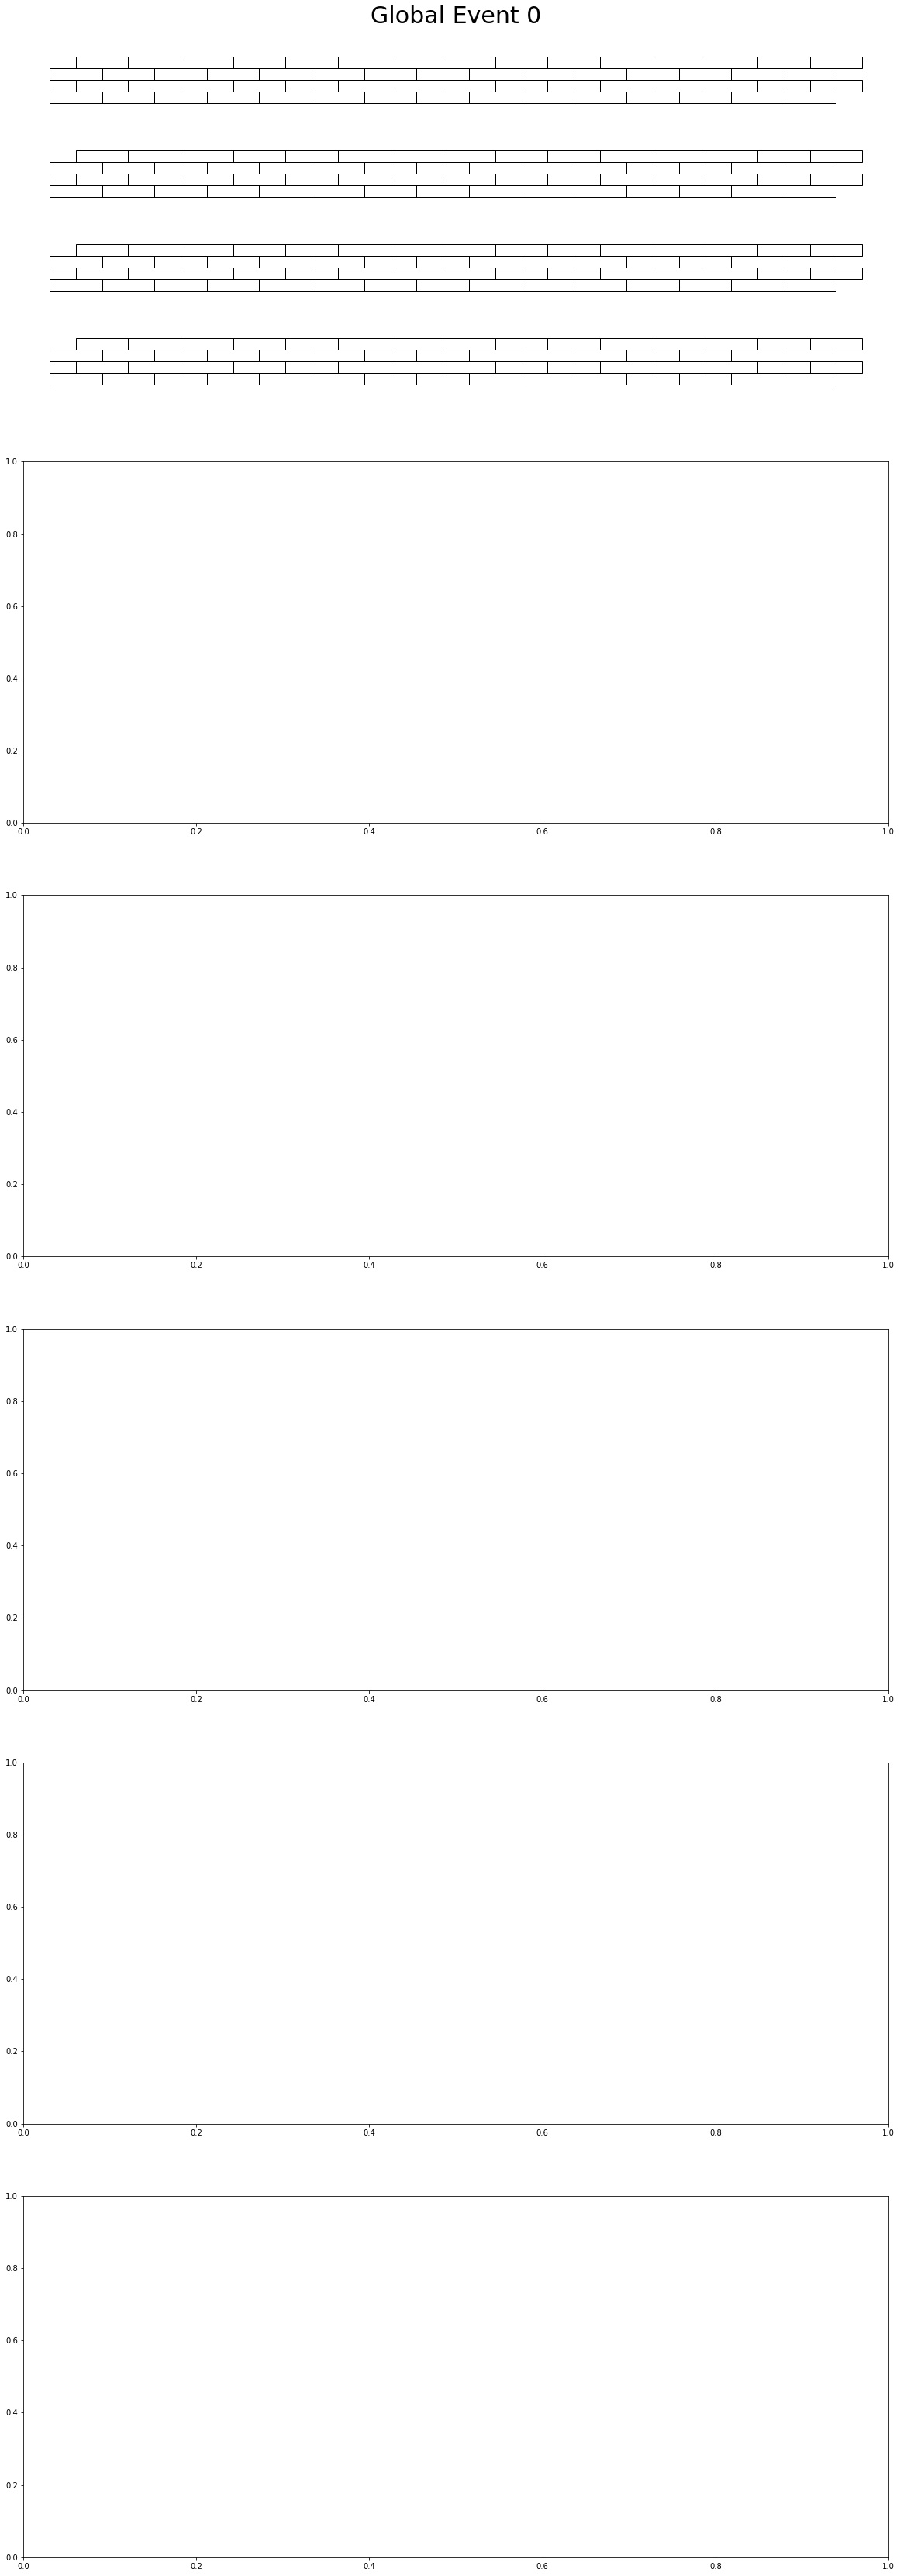

In [126]:
fig,ax = plt.subplots(nrows=len(event),ncols=1,figsize=(20,60))

#draw selected events
for i,ev in enumerate(event):

    global_event=ev[ev["chan"]<=128].sort_values(by="chamber").reset_index(drop=True)
    local=global_event.groupby("chamber")
    local_events=[local.get_group(x) for x in local.groups]

    #draw events
    dx = 1
    dy = 1/2
    gap=4

    ax[i].set_title("Global Event %d" %i,fontsize=30)
    draw_detector(ax[i])

    for j in range(len(local_events)):

        single=local_events[j].reset_index(drop=True)#.drop(["level_0","index"],axis=1)
        boxes(ax[i],centres(single)[0],centres(single)[1])
        ax[i].errorbar(*centres(single),dy/2,dx/2,fmt='o')

    ax[i].text(x=7.5,y=5*dy+3*gap,s="Chamber 3",fontsize=20)
    ax[i].text(x=7.5,y=5*dy+2*gap,s="Chamber 2",fontsize=20)
    ax[i].text(x=7.5,y=5*dy+gap,s="Chamber 1",fontsize=20)
    ax[i].text(x=7.5,y=5*dy,s="Chamber 0",fontsize=20)

plt.show()
